## Load the data in pickle file 

In [73]:
# Load the data
import pickle
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as netcdf

with open('ssp585_time_series.pkl', 'rb') as f:
    dic_ssp585 = pickle.load(f)

In [74]:
import os 

# Get the list of all files and directories
path = "/net/atmos/data/cmip6-ng/tos/ann/g025"
dir_list = os.listdir(path)

print("Files and directories in '", path, "' :")

list_model = []
list_forcing = []

for idx, file in enumerate(dir_list):

    file_split = file.split("_")
    
    # extract model names
    model_name = file_split[2]
    forcing = file_split[3]
    run_name = file_split[4]
    
    list_model.append(model_name)
    list_forcing.append(forcing)
    
model_names = list(set(list_model))
forcing_names = list(set(list_forcing))

Files and directories in ' /net/atmos/data/cmip6-ng/tos/ann/g025 ' :


### Load the real observations

In [75]:
import netCDF4 as netcdf

# define the file
file = '/net/h2o/climphys3/simondi/cope-analysis/data/erss/sst_annual_g050_mean_19812014_centered.nc'

# read the dataset
file2read = netcdf.Dataset(file,'r')

# load longitude, latitude and sst monthly means
lon = np.array(file2read.variables['lon'][:])
lat = np.array(file2read.variables['lat'][:])
sst = np.array(file2read.variables['sst'])

# define grid
lat_grid, lon_grid = np.meshgrid(lat, lon, indexing='ij')

time_period = 33
grid_lat_size = lat.shape[0]
grid_lon_size = lon.shape[0]

# Preprocessing of the data: $(x_{i,t,m}^{p})_{i=1,\ldots,I, t=1,\ldots,T,m=1,\ldots,M, p=1,\ldots,d}$
## $i$: ensemble member (run) index
## $t$: time index
## $m$: model index
## $p$: grid cell index

#### Keep the model with at least 3 ensemble memebers and downscale the data from latitude 144 -> 36 with local averaging (to match with ensemble methods

In [76]:
import skimage

# first filter out the models that do not contain ensemble members 
dic_reduced_ssp585 = {}

for m in list(dic_ssp585.keys()):
    if len(dic_ssp585[m].keys()) > 2:
        dic_reduced_ssp585[m] = dic_ssp585[m].copy()
        for idx_i, i in enumerate(dic_ssp585[m].keys()):
            dic_reduced_ssp585[m][i] = skimage.transform.downscale_local_mean(dic_reduced_ssp585[m][i],(1,2,2))
            lat_size = dic_reduced_ssp585[m][i][0,:,:].shape[0]
            lon_size = dic_reduced_ssp585[m][i][0,:,:].shape[1]

# Store Nan indices by taking maximum of nan coverage among the anomalies 

In [77]:
nan_idx = []
for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    for idx_i,i in enumerate(dic_reduced_ssp585[m].keys()):    
        # for t in enumerate(range(time_period)[:2]):
            # print(np.where(np.isnan(dic_reduced_ssp585[m][i][t,:,:].ravel())==True))
        nan_idx_tmp = list(np.where(np.isnan(dic_reduced_ssp585[m][i][0,:,:].ravel())==True)[0])
        # nan_idx_tmp_tt = list(np.where(np.isnan(dic_reduced_ssp585[m][i][1,:,:].ravel())==True)[0])
        
        nan_idx = list(set(nan_idx) | set(nan_idx_tmp))

notnan_idx = list(set(list(range(lon_size*lat_size))) - set(nan_idx))

### 1) Compute anomalies: $\displaystyle \overline{x}_{i,t,m}^p = x_{i,t,m}^p - \frac{1}{t_{\mathrm{ref}}^f - t_{\mathrm{ref}}^s} \sum_{t= t_{\mathrm{ref}}^s}^{t_{\mathrm{ref}}^f} \sum_{i=1}^I x_{i,t,m}^p$

In [78]:
# second, for each model we compute the anomalies 
dic_processed_ssp585 = {}

import numpy as np

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_processed_ssp585[m] = dic_reduced_ssp585[m].copy()
    
    mean_ref_ensemble = 0
    for idx_i, i in enumerate(dic_reduced_ssp585[m].keys()):
        y_tmp = dic_reduced_ssp585[m][i][131:164,:,:].copy().reshape(time_period, lat_size*lon_size)
        y_tmp[:,nan_idx] = float('nan')
        
        
        if idx_i == 0:
            mean_ref_ensemble = np.nanmean(y_tmp,axis=0)/ len(dic_processed_ssp585[m].keys())
        else:
            mean_ref_ensemble += np.nanmean(y_tmp,axis=0)/ len(dic_processed_ssp585[m].keys())

    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
        dic_processed_ssp585[m][i] = y_tmp - mean_ref_ensemble
        print(dic_processed_ssp585[m][i][10,:])

/tmp/ipykernel_21069/3950760596.py:16: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(y_tmp,axis=0)/ len(dic_processed_ssp585[m].keys())
/tmp/ipykernel_21069/3950760596.py:18: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble += np.nanmean(y_tmp,axis=0)/ len(dic_processed_ssp585[m].keys())


[       nan        nan        nan ... 0.00550096 0.00637611 0.00608942]
[       nan        nan        nan ... 0.00550096 0.00637611 0.00608942]
[       nan        nan        nan ... 0.00550096 0.00637611 0.00608942]
[       nan        nan        nan ... 0.00550096 0.00637611 0.00608942]
[       nan        nan        nan ... 0.00550096 0.00637611 0.00608942]
[       nan        nan        nan ... 0.00550096 0.00637611 0.00608942]
[       nan        nan        nan ... 0.00550096 0.00637611 0.00608942]
[       nan        nan        nan ... 0.00550096 0.00637611 0.00608942]
[       nan        nan        nan ... 0.00550096 0.00637611 0.00608942]
[       nan        nan        nan ... 0.00550096 0.00637611 0.00608942]
[       nan        nan        nan ... 0.00550096 0.00637611 0.00608942]
[       nan        nan        nan ... 0.00550096 0.00637611 0.00608942]
[       nan        nan        nan ... 0.00550096 0.00637611 0.00608942]
[       nan        nan        nan ... 0.00550096 0.00637611 0.00

### 2) Compute the forced response: 
#### - Mean over space: $\displaystyle y_{i,t,m} = \frac{1}{P} \sum_{p=1}^P x_{i,t,m}^p$
#### - Mean over ensemble members: $\displaystyle \overline{y}_{t,m} = \frac{1}{I} \sum_{i=1}^I y_{i,t,m}$
#### - Set the mean to all the ensemble member forced responses: $y_{i,t,m} \colon= \overline{y}_{t,m}$
#### - Centering with respect to a given reference period: $\displaystyle y_{i,t,m} = y_{i,t,m} - \frac{1}{t_{\mathrm{ref}}^f - t_{\mathrm{ref}}^s} \sum_{t= t_{\mathrm{ref}}^s}^{t_{\mathrm{ref}}^f} \overline{y}_{t,m}$

In [79]:
# compute the forced response
dic_forced_response_ssp585 = dict({})

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_forced_response_ssp585[m] = dic_reduced_ssp585[m].copy()

    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        
        y_tmp = dic_reduced_ssp585[m][i][131:164,:,:].copy().reshape(time_period, lat_size*lon_size)
        y_tmp[:,nan_idx] = float('nan')

        if idx_i == 0:
            mean_spatial_ensemble = np.nanmean(y_tmp,axis=1)/ len(dic_forced_response_ssp585[m].keys())
        else:
            mean_spatial_ensemble += np.nanmean(y_tmp,axis=1)/ len(dic_forced_response_ssp585[m].keys())

    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):        
        dic_forced_response_ssp585[m][i] = mean_spatial_ensemble - np.nanmean(mean_spatial_ensemble)
    

## Now we can use the data to run some simple regression models

In [80]:
y_forced_response = {}
x_predictor = {}

for idx_m,m in enumerate(dic_processed_ssp585.keys()):
    y_forced_response[m] = {}
    x_predictor[m] = {}

    
    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        
        y_forced_response[m][i] = dic_forced_response_ssp585[m][i]
        x_predictor[m][i] = dic_processed_ssp585[m][i]
        x_predictor[m][i][:,nan_idx] = float('nan')

In [82]:
import torch 

# compute the variance
variance_processed_ssp585 = {}
std_processed_ssp585 = {}
for idx_m,m in enumerate(x_predictor.keys()):
    variance_processed_ssp585[m] = {}
    arr_tmp = np.zeros((len(x_predictor[m].keys()),33))
    
    for idx_i, i in enumerate(list(x_predictor[m].keys())):
        arr_tmp[idx_i,:] = np.nanmean(x_predictor[m][i],axis=1)

    arr_tmp_values = np.zeros((len(x_predictor[m].keys()),33))
    for idx_i, i in enumerate(x_predictor[m].keys()):
        arr_tmp_values[idx_i,:] = (y_forced_response[m][i] - arr_tmp[idx_i,:])**2

    variance_processed_ssp585[m] = torch.nanmean(torch.from_numpy(arr_tmp_values),axis=0)

### Define optimizaton problem with Pytorch

In [83]:
# Data preprocessing
x_train = {}
y_train = {}

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    x_train[m] = {}
    y_train[m] = {}
    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
        x_train[m][i] = torch.nan_to_num(torch.from_numpy(x_predictor[m][i])).to(torch.float64)
        y_train[m][i] = torch.from_numpy(y_forced_response[m][i]).to(torch.float64)

In [84]:
def ridge_estimator(model_out,x,y,vars,lambda_):
    """
    Compute the ridge estimator given gammas.
    """
    idx_start = 0
    for idx_m,m in enumerate(list(x.keys())):
        if m!= model_out:
            if idx_start==0:
                X_tmp = x[m]
                y_tmp = y[m]
                D = (1/vars[m])*torch.eye(x[m].shape[0])
                idx_start +=1
            else:
                X_tmp = torch.cat((X_tmp,x[m]),0)
                y_tmp = torch.cat((y_tmp,y[m]),0)
                D_tmp = ((1/vars[m]) * torch.eye(x[m].shape[0])).to(torch.float64)
                D = torch.block_diag(D, D_tmp).to(torch.float64)

    A = torch.matmul(torch.matmul(X_tmp.T, D),X_tmp) + lambda_ * torch.eye(X_tmp.shape[1])
    b = torch.matmul(torch.matmul(X_tmp.T,D),y_tmp)
    
    return torch.linalg.solve(A,b)

In [85]:
def train_ridge_regression(x,y,vars,lon_size,lat_size,models,lambda_,nbEpochs=100,verbose=True):
    """
    Given a model m, learn parameter β^m such that β^m = argmin_{β}(||y_m - X_m^T β||^2) ).

    Args:
        - x, y: training set and training target 
        - lon_size, lat_size: longitude and latitude grid size (Int)
        - lambda_: regularizer coefficient (float)
        - nbepochs: number of optimization steps (Int)
        - verbose: display logs (bool)
    """

    # define variable beta
    beta = torch.zeros(lat_size*lon_size).to(torch.float64)
    beta.requires_grad_(True)  
                          
    # define optimizer
    optimizer = torch.optim.Adam([beta],lr=1e-3)

    # stopping criterion
    criteria = torch.tensor(0.0)
    criteria_tmp = torch.tensor(1.0) 
    epoch = 0
            
    # --- optimization loop ---                
    while (torch.abs(criteria - criteria_tmp) >= 1e-4) & (epoch <= nbEpochs):

        # update criteria
        criteria_tmp = criteria.clone()
        epoch +=1
                      
        optimizer.zero_grad()
        ############### Define loss function ##############
                    
        # first term: ||Y - X - Rb ||
        res = torch.zeros(len(models),33)

        
        for idx_m, m in enumerate(models):
            for idx_i, i in enumerate(x[m].keys()):
                res[idx_m,:] += (y[m][i] - torch.matmul(x[m][i],beta))**2/vars[m]
            res[idx_m,:] = res[idx_m,:]/len(x[m].keys())

        obj = torch.mean(res)
        obj += lambda_*torch.norm(beta,p=2)**2
                    
        #define loss function
        loss = obj
                    
        # Use autograd to compute the backward pass. 
        loss.backward(retain_graph=True)               
        
        # take a step into optimal direction of parameters minimizing loss
        optimizer.step()       
        
        if(verbose==True):
            if(epoch % 10 == 0):
                print('Epoch ', epoch, 
                    ', loss=', loss.detach().item()
                    )

        criteria = loss
    return beta.detach().clone()

In [224]:
def train_robust_model(x,y,vars,lon_size,lat_size,models,lambda_,alpha_=1.0,nbEpochs=100,verbose=True):
    """
    Learn parameter β such that β = argmin( log Σ_m exp(||y_m - X_m^T β||^2) ).

    Args:
        - x,y : location, observation 
        - lon_size, lat_size: longitude and latitude grid size (Int)
        - models: (sub)list of models (list)
        - alpha_: softmax coefficient (float)
        - nbepochs: number of optimization steps (Int)
        - verbose: display logs (bool)
    """

    # define variable beta
    beta = (1/(lon_size*lat_size))*torch.ones(lon_size*lat_size).to(torch.float64)
    # beta = torch.zeros(lon_size*lat_size).to(torch.float64)
    beta.requires_grad_(True)  

    # define optimizer
    optimizer = torch.optim.Adam([beta],lr=1e-3)

    # stopping criterion
    criteria = torch.tensor(0.0)
    criteria_tmp = torch.tensor(1.0) 
    epoch = 0
    training_loss = torch.zeros(nbEpochs)
            
    # --- optimization loop ---                
    while (torch.abs(criteria - criteria_tmp) >= 1e-6) & (epoch < nbEpochs):

        
        # update criteria
        criteria_tmp = criteria.clone()
                      
        optimizer.zero_grad()
        ############### Define loss function ##############
                    
        # first term: ||Y - X - Rb ||
        # obj = torch.tensor(0.0)
        # for m in models:
        #     obj += torch.exp((1/alpha_)*torch.mean((y[m] - torch.matmul(x[m],beta))**2)/vars[m])
    
        # obj = alpha_*torch.log(obj)


        ######### Test #####################
        res = torch.zeros(len(models),33)

        for idx_m, m in enumerate(models):
            for idx_i, i in enumerate(x[m].keys()):
                res[idx_m,:] += (y[m][i] - torch.matmul(x[m][i],beta))**2/vars[m]
            res[idx_m,:] = res[idx_m,:]/len(x[m].keys())
            
        obj = alpha_*torch.logsumexp((1/alpha_)* torch.mean(res,axis=1),0)

        obj += lambda_*torch.norm(beta,p=2)**2
                    
        #define loss function
        loss = obj

        training_loss[epoch] = loss.detach().item()
                    
        # Use autograd to compute the backward pass. 
        loss.backward()               
        
        # take a step into optimal direction of parameters minimizing loss
        optimizer.step()              

        if(verbose==True):
            if(epoch % 2 == 0):
                print('Epoch ', epoch, 
                        ', loss=', training_loss[epoch].detach().item()
                        )
        criteria = loss
        epoch +=1

    plt.figure()
    plt.plot(range(nbEpochs),training_loss)
    plt.title('Training loss')
    plt.ylabel('Loss')
    plt.xlabel('iterations')
    plt.show()
    return beta.detach().clone()

In [ ]:
alpha_ = 0.001
lambda_ = 0.01
selected_models = list(dic_reduced_ssp585.keys())

beta_robust = train_robust_model(x_train,y_train,variance_processed_ssp585,\
                                  lat_size,lon_size,\
                                  selected_models,\
                                  lambda_,alpha_,nbEpochs=150,verbose=True)

beta_ridge = train_ridge_regression(x_train,y_train,variance_processed_ssp585,\
                                    lat_size,lon_size,\
                                    selected_models,\
                                    lambda_,nbEpochs=100,verbose=True)

Epoch  0 , loss= 3747.006103515625
Epoch  2 , loss= 5962.82763671875
Epoch  4 , loss= 32651.755859375
Epoch  6 , loss= 3460.7490234375
Epoch  8 , loss= 13780.0546875
Epoch  10 , loss= 9074.5087890625
Epoch  12 , loss= 8391.2919921875
Epoch  14 , loss= 9152.0009765625
Epoch  16 , loss= 4065.074951171875
Epoch  18 , loss= 1481.166748046875
Epoch  20 , loss= 11307.330078125
Epoch  22 , loss= 17672.71875
Epoch  24 , loss= 2572.73388671875
Epoch  26 , loss= 12322.8876953125
Epoch  28 , loss= 19896.55859375
Epoch  30 , loss= 487.7295227050781
Epoch  32 , loss= 9725.5625
Epoch  34 , loss= 8110.921875
Epoch  36 , loss= 294.1687927246094
Epoch  38 , loss= 7189.8671875
Epoch  40 , loss= 2350.822998046875
Epoch  42 , loss= 1108.422119140625
Epoch  44 , loss= 4192.12353515625
Epoch  46 , loss= 678.3694458007812
Epoch  48 , loss= 3356.347412109375
Epoch  50 , loss= 6122.8583984375
Epoch  52 , loss= 88.7646713256836
Epoch  54 , loss= 3995.830078125
Epoch  56 , loss= 4408.720703125
Epoch  58 , loss= 

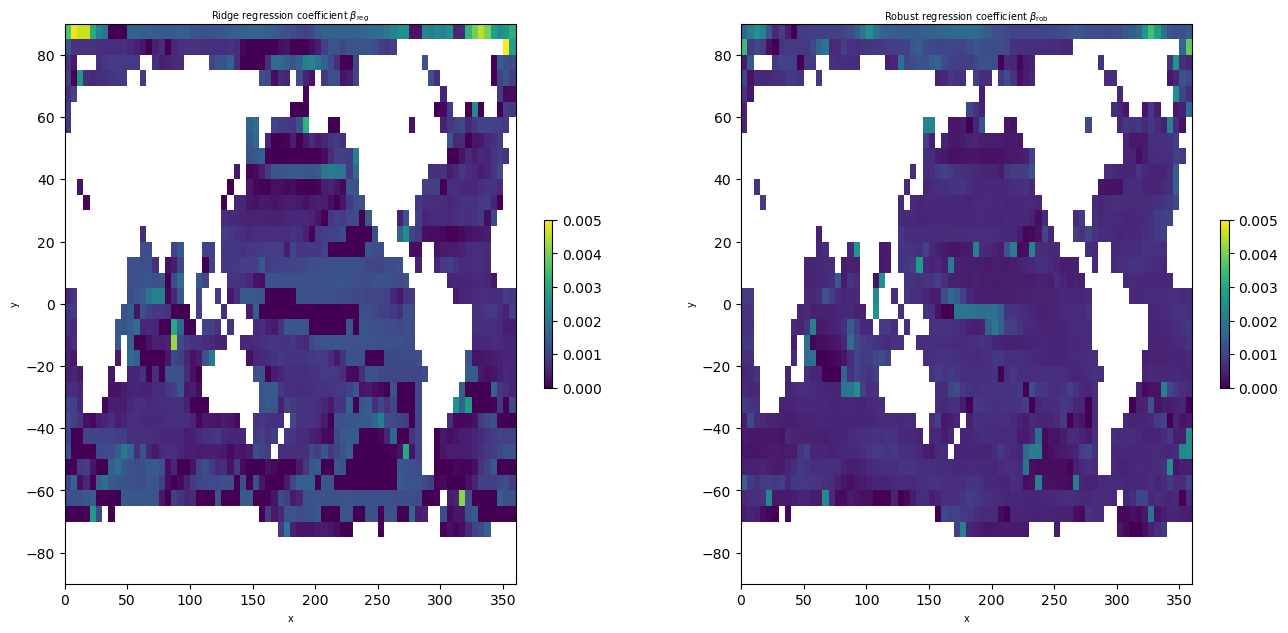

In [230]:
# define beta to plot
beta_ridge_tmp = beta_ridge.detach().clone()
beta_ridge_tmp[nan_idx] = float('nan')
beta_ridge_tmp = beta_ridge_tmp.detach().numpy().reshape(lat_size,lon.shape[0])

# define robust beta
beta_robust_tmp = beta_robust.detach().clone()
beta_robust_tmp[nan_idx] = float('nan')
beta_robust_tmp = beta_robust_tmp.detach().numpy().reshape(lat.shape[0],lon.shape[0])

fig0 = plt.figure(figsize=(16,16))           

ax0 = fig0.add_subplot(2, 2, 1)        
ax0.set_title(r'Ridge regression coefficient $\beta_{\mathrm{reg}}$', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,beta_ridge_tmp,vmin=-0.00,vmax = 0.005)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

ax1 = fig0.add_subplot(2, 2, 2)        
ax1.set_title(r'Robust regression coefficient $\beta_{\mathrm{rob}}$', size=7,pad=3.0)
im1 = ax1.pcolormesh(lon_grid,lat_grid,beta_robust_tmp,vmin=-0.00,vmax = 0.005)
plt.colorbar(im1, ax=ax1, shrink=0.3)
ax1.set_xlabel(r'x', size=7)
ax1.set_ylabel(r'y', size=7)

plt.show()

### plot the softmax coefficients

/tmp/ipykernel_21069/996538885.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  gamma = torch.nn.functional.softmax(gamma)
/tmp/ipykernel_21069/996538885.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=-90)


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])


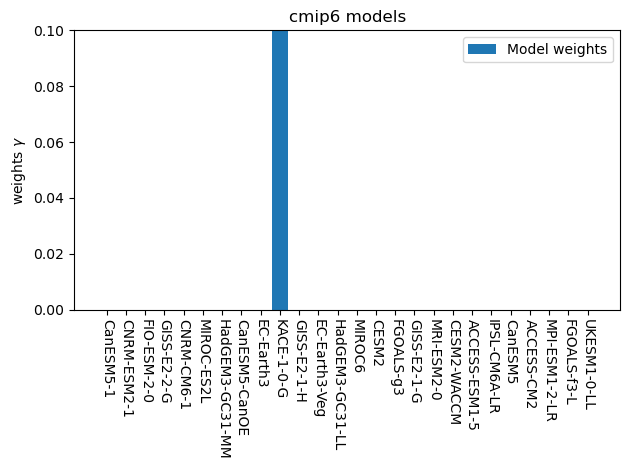

In [231]:
# compute the coefficient of the robust model
M = len(list(dic_reduced_ssp585.keys()))
gamma = torch.zeros(M)
res = torch.zeros(M,33)

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    
    for idx_i, i in enumerate(dic_reduced_ssp585[m].keys()):
        res[idx_m,:] += (y_train[m][i] - torch.matmul(x_train[m][i],beta_robust))**2/variance_processed_ssp585[m]
        
    res[idx_m,:] = res[idx_m,:]/len(dic_reduced_ssp585[m].keys())
    gamma[idx_m] = (1/alpha_)*torch.mean(res[idx_m,:],axis=0)

gamma = torch.nn.functional.softmax(gamma)
print(gamma)


# plot the model contributions
fig, ax = plt.subplots()
models = list(dic_reduced_ssp585.keys())
weights = list(gamma.detach().numpy())

ax.bar(models, weights,label='Model weights')
ax.set_ylabel(r'weights $\gamma$')
ax.set_ylim(0.0,0.1)
ax.set_title('cmip6 models')
ax.legend()
ax.set_xticklabels(models, rotation=-90)
plt.tight_layout()
plt.show()

## Leave-one-out procedure

In [17]:
def compute_weights(x,y,vars,beta,lon_size,lat_size,models,alpha_):
    """
    Plot and return the weights of the robust model.
    """
    M = len(list(dic_reduced_ssp585.keys()))
    gamma = torch.zeros(M)
    res = torch.zeros(M,33)
    
    for idx_m,m in enumerate(x.keys()):
        
        for idx_i, i in enumerate(x[m].keys()):
            res[idx_m,:] += (y[m][i] - torch.matmul(x[m][i],beta))**2/vars[m]
        res[idx_m,:] = res[idx_m,:]/len(x[m].keys())
        gamma[idx_m] = (1/alpha_)*torch.mean(res[idx_m,:],axis=0)

    gamma = torch.nn.functional.softmax(gamma)
    
    # plot the model contributions
    weights = {m: gamma[idx_m].item() for idx_m,m in enumerate(models)}

    return weights

In [18]:
def leave_one_out(model_out,x,y,vars,lon_size,lat_size,lambda_,method='robust',alpha_=1.0,nbEpochs=500,verbose=True):

    # Data preprocessing
    x_train = {}
    y_train = {}

    x_test = {}
    y_test = {}
    selected_models = []

    for idx_m,m in enumerate(x.keys()):
        if m != model_out:

            x_train[m] = {}
            y_train[m] = {}
            
            # selected models 
            selected_models.append(m)
            
            for idx_i, i in enumerate(x[m].keys()):
                
                
                x_train[m][i] = torch.from_numpy(np.nan_to_num(x[m][i]).reshape(x[m][i].shape[0],lon_size*lat_size)).to(torch.float64)
                y_train[m][i] = torch.from_numpy(y[m][i]).to(torch.float64)
        
        else:
            for idx_i, i in enumerate(x[model_out].keys()):
                x_test[i] = np.nan_to_num(x[model_out][i]).reshape(x[model_out][i].shape[0],lon_size*lat_size)            
                y_test[i] = y[model_out][i]

    # if method = robust, then we train the robust
    if method == 'robust':
        beta = train_robust_model(x_train,y_train,vars,\
                                    lon_size,lat_size,\
                                    selected_models,\
                                    alpha_,lambda_,nbEpochs,verbose)

    else:
        beta = train_ridge_regression(x_train,y_train,vars,\
                                        lon_size,lat_size,\
                                        selected_models,\
                                        lambda_,nbEpochs,verbose)

    y_pred={}
    for idx_i, i in enumerate(x[model_out].keys()):
        y_pred[i] = np.dot(x_test[i],beta)

    if method == 'robust':
        weights = compute_weights(x_train,y_train,vars,beta,lon_size,lat_size,selected_models,alpha_)
    else:
        weights = {m: (1/len(x.keys())) for m in x.keys()}

    return beta, y_pred, y_test, weights

In [46]:
def leave_one_out_procedure(x,y,vars,lon_size,lat_size,lambda_,method='robust',alpha_=1.0,nbEpochs=500,verbose=True):

    beta = {}
    y_pred = {}
    y_test = {}
    rmse = {}
    weights = {m: 0.0 for idx_m, m in enumerate(x.keys())}
    
    for idx_m, m in enumerate(x.keys()):
        
        beta[m], y_pred[m], y_test[m], weights_tmp = leave_one_out(m,x,y,vars,lon_size,lat_size,lambda_,method,alpha_,nbEpochs,verbose)

        rmse[m] = 0
        for idx_i, i in enumerate(x[m].keys()):
            rmse[m] += np.mean(((y_test[m][i] - y_pred[m][i])**2/vars[m]).detach().numpy())
        rmse[m] = rmse[m]/len(x[m].keys())
            
        # compute the weight when a single model is out 
        if method == 'robust':    
            for m_tmp in list(x.keys()):
                if m_tmp != m:
                    weights[m_tmp] += (1/(len(x.keys())))* weights_tmp[m_tmp]

        # print the rmse
        print('RMSE on model ', m, ' : ', rmse[m])

    print("Check that the weights sum to 1.0 ",np.sum(np.array(list(weights.values()))))
    ################# plot the observation vs prediction accuracy #####################################
    # fig, axs = plt.subplots(6,5, figsize=(15,10), facecolor='w', edgecolor='k')
    # fig.subplots_adjust(hspace = 2.0, wspace=1.0)

    # axs = axs.ravel()
    
    # for idx_m, m in enumerate(x.keys()):
        
    #     # create the function y=x
    #     minx = np.min(y_test[m])
    #     maxx = np.max(y_test[m])
    #     x_tmp = np.linspace(minx,maxx,100)
    #     y_tmp = x_tmp

    #     axs[idx_m].scatter(y_test[m],y_pred[m],label=m,s=0.1)
    #     axs[idx_m].plot(x_tmp,y_tmp,color='r',linewidth=0.5)
    #     axs[idx_m].set_title(m)

    # for i in range(len(x.keys()),30):
    #     fig.delaxes(axs[i])

    # fig.tight_layout()
    # plt.savefig("results/pred_vs_real_"+str(alpha_)+"_"+str(lambda_)+".eps", dpi=150)
    # plt.show()

    # ############################### plot the residuals #####################################
    # fig, axs = plt.subplots(6,5, figsize=(15,10), facecolor='w', edgecolor='k')
    # fig.subplots_adjust(hspace = 2.0, wspace=1.0)

    # axs = axs.ravel()
    
    # for idx_m, m in enumerate(x.keys()):

    #     axs[idx_m].scatter(y_test[m],y_test[m] - y_pred[m],label=m,s=0.1)
    #     axs[idx_m].plot(x_tmp,np.zeros_like(x_tmp),color='r',linewidth=0.5)
    #     axs[idx_m].set_title(m)

    # for i in range(len(x.keys()),30):
    #     fig.delaxes(axs[i])

    # fig.tight_layout()
    # plt.savefig("results/residuals_"+method+"_"+str(alpha_)+"_"+str(lambda_)+".eps", dpi=150)
    # plt.show()
    
    # ############## plot the beta map for each leave-one-out run #####################################
    # fig, axs = plt.subplots(6,5, figsize=(15,10), facecolor='w', edgecolor='k')
    # fig.subplots_adjust(hspace = 2.0, wspace=1.0)

    # axs = axs.ravel()
    
    # for idx_m, m in enumerate(x.keys()):
        
    #     beta_tmp = beta[m].detach().clone()
    #     beta_tmp[nans_idx] = float('nan')
    #     beta_tmp = beta_tmp.detach().numpy().reshape(lat_size,lon_size)

    #     axs[idx_m].set_title(m)
    #     im0 = axs[idx_m].pcolormesh(lon_grid,lat_grid,beta_tmp,vmin=-0.00,vmax = 0.005)

    # plt.colorbar(im0, ax=axs[idx_m], shrink=0.5)

    # for i in range(len(x.keys()),30):
    #     fig.delaxes(axs[i])

    # fig.tight_layout()
    # plt.savefig("results/beta_map_"+method+"_"+str(alpha_)+"_"+str(lambda_)+".eps", dpi=150)
    # plt.show()

    
    ################# plot the weights #################
    if method == 'robust':    
        fig, ax = plt.subplots()
        models = list(x.keys()) 
        weights_plot = list(weights.values()) 
        ax.bar(models, weights_plot,label='Model weights')
        ax.set_ylabel(r'weights $\gamma$')
        ax.set_title('cmip6 models')
        ax.legend()
        ax.set_xticklabels(models, rotation=-90)
        plt.tight_layout()
        plt.savefig("results/weights_"+method+"_"+str(alpha_)+"_"+str(lambda_)+".eps", dpi=150)
        plt.show()

    ################# plot the rmse #################
    fig, ax = plt.subplots()
    models = list(x.keys()) 
    rmse_plot = list(rmse.values()) 
    ax.bar(models, rmse_plot,label='rmse')
    ax.set_ylabel(r'LOO')
    ax.set_title('LOO rmse')
    ax.legend()
    ax.set_xticklabels(models, rotation=-90)
    plt.tight_layout()
    plt.savefig("results/rmse_"+method+"_"+str(alpha_)+"_"+str(lambda_)+".eps", dpi=150)
    plt.show()
    

    return beta, rmse, weights

Epoch  0 , loss= 22057.931640625
Epoch  5 , loss= 17060.654296875
Epoch  10 , loss= 9658.51171875
Epoch  15 , loss= 1352.849365234375
Epoch  20 , loss= 8252.509765625
Epoch  25 , loss= 586.9561767578125
Epoch  30 , loss= 2336.751220703125
Epoch  35 , loss= 3328.600830078125
Epoch  40 , loss= 927.658203125
Epoch  45 , loss= 175.70643615722656
Epoch  50 , loss= 301.4554138183594
Epoch  55 , loss= 198.1667938232422
Epoch  60 , loss= 821.1934204101562
Epoch  65 , loss= 1095.223876953125
Epoch  70 , loss= 1076.6458740234375
Epoch  75 , loss= 950.1571655273438
Epoch  80 , loss= 896.3052978515625
Epoch  85 , loss= 248.84803771972656
Epoch  90 , loss= 189.59703063964844
Epoch  95 , loss= 355.1739501953125


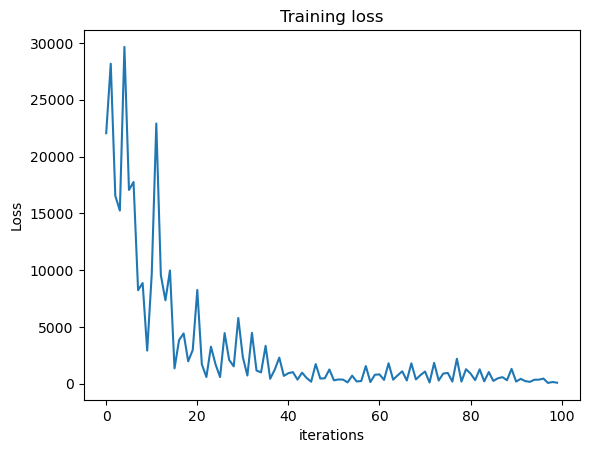

/tmp/ipykernel_21069/585271446.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  gamma = torch.nn.functional.softmax(gamma)


RMSE on model  CanESM5-1  :  8.558535068978859
Epoch  0 , loss= 22057.931640625
Epoch  5 , loss= 17060.654296875
Epoch  10 , loss= 9658.51171875
Epoch  15 , loss= 1352.849365234375
Epoch  20 , loss= 8252.509765625
Epoch  25 , loss= 586.9561767578125
Epoch  30 , loss= 2336.751220703125
Epoch  35 , loss= 3328.600830078125
Epoch  40 , loss= 927.658203125
Epoch  45 , loss= 175.70643615722656
Epoch  50 , loss= 301.4554138183594
Epoch  55 , loss= 198.1667938232422
Epoch  60 , loss= 821.1934204101562
Epoch  65 , loss= 1095.223876953125
Epoch  70 , loss= 1076.6458740234375
Epoch  75 , loss= 950.1571655273438
Epoch  80 , loss= 896.3052978515625
Epoch  85 , loss= 248.84803771972656
Epoch  90 , loss= 189.59703063964844
Epoch  95 , loss= 355.1739501953125


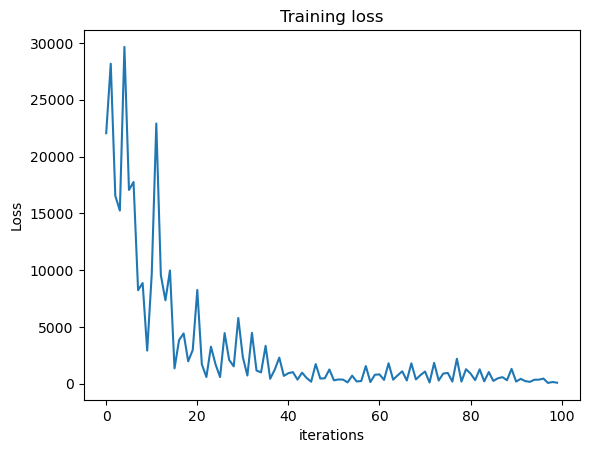

RMSE on model  CNRM-ESM2-1  :  15.420835892654134
Epoch  0 , loss= 22057.931640625
Epoch  5 , loss= 17060.654296875
Epoch  10 , loss= 9658.51171875
Epoch  15 , loss= 1352.849365234375
Epoch  20 , loss= 8252.509765625
Epoch  25 , loss= 586.9561767578125
Epoch  30 , loss= 2336.751220703125
Epoch  35 , loss= 3328.600830078125
Epoch  40 , loss= 927.658203125
Epoch  45 , loss= 175.70643615722656
Epoch  50 , loss= 301.4554138183594
Epoch  55 , loss= 198.1667938232422
Epoch  60 , loss= 821.1934204101562
Epoch  65 , loss= 1095.223876953125
Epoch  70 , loss= 1076.6458740234375
Epoch  75 , loss= 950.1571655273438
Epoch  80 , loss= 896.3052978515625
Epoch  85 , loss= 248.84803771972656
Epoch  90 , loss= 189.59703063964844
Epoch  95 , loss= 355.1739501953125


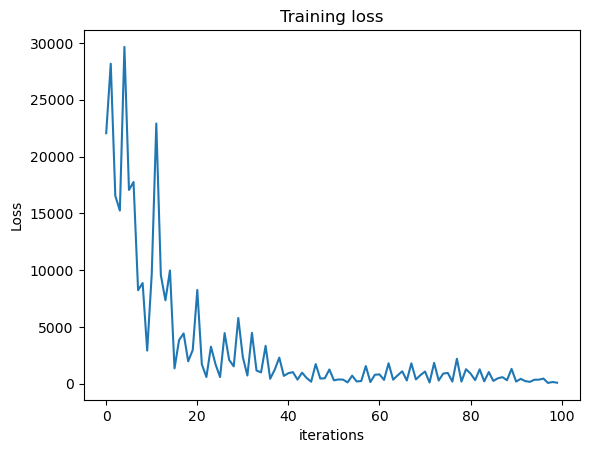

RMSE on model  FIO-ESM-2-0  :  44.5926665392956
Epoch  0 , loss= 22057.931640625
Epoch  5 , loss= 17060.654296875
Epoch  10 , loss= 9658.51171875
Epoch  15 , loss= 1352.849365234375
Epoch  20 , loss= 8252.509765625
Epoch  25 , loss= 586.9561767578125
Epoch  30 , loss= 2336.751220703125
Epoch  35 , loss= 3328.600830078125
Epoch  40 , loss= 927.658203125
Epoch  45 , loss= 175.70643615722656
Epoch  50 , loss= 301.4554138183594
Epoch  55 , loss= 198.1667938232422
Epoch  60 , loss= 821.1934204101562
Epoch  65 , loss= 1095.223876953125
Epoch  70 , loss= 1076.6458740234375
Epoch  75 , loss= 950.1571655273438
Epoch  80 , loss= 896.3052978515625
Epoch  85 , loss= 248.84803771972656
Epoch  90 , loss= 189.59703063964844
Epoch  95 , loss= 355.1739501953125


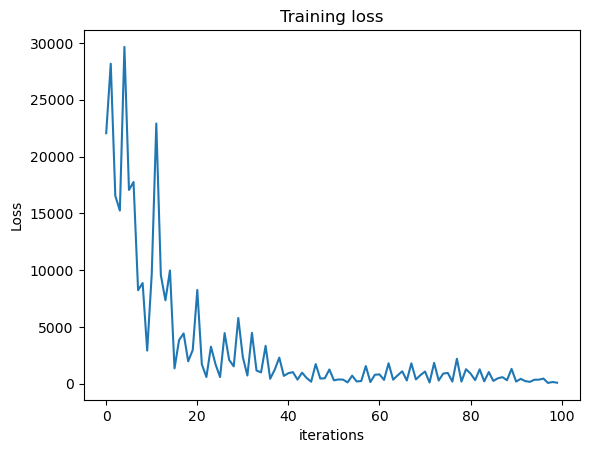

RMSE on model  GISS-E2-2-G  :  1.3277637022738509
Epoch  0 , loss= 22057.931640625
Epoch  5 , loss= 17060.654296875
Epoch  10 , loss= 9658.51171875
Epoch  15 , loss= 1352.849365234375
Epoch  20 , loss= 8252.509765625
Epoch  25 , loss= 586.9561767578125
Epoch  30 , loss= 2336.751220703125
Epoch  35 , loss= 3328.600830078125
Epoch  40 , loss= 927.658203125
Epoch  45 , loss= 175.70643615722656
Epoch  50 , loss= 301.4554138183594
Epoch  55 , loss= 198.1667938232422
Epoch  60 , loss= 821.1934204101562
Epoch  65 , loss= 1095.223876953125
Epoch  70 , loss= 1076.6458740234375
Epoch  75 , loss= 950.1571655273438
Epoch  80 , loss= 896.3052978515625
Epoch  85 , loss= 248.84803771972656
Epoch  90 , loss= 189.59703063964844
Epoch  95 , loss= 355.1739501953125


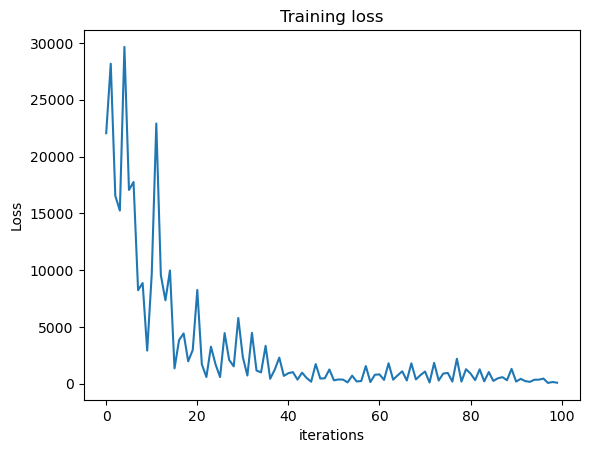

RMSE on model  CNRM-CM6-1  :  7.546152097892473
Epoch  0 , loss= 22057.931640625
Epoch  5 , loss= 17060.654296875
Epoch  10 , loss= 9658.51171875
Epoch  15 , loss= 1352.849365234375
Epoch  20 , loss= 8252.509765625
Epoch  25 , loss= 586.9561767578125
Epoch  30 , loss= 2336.751220703125
Epoch  35 , loss= 3328.600830078125
Epoch  40 , loss= 927.658203125
Epoch  45 , loss= 175.70643615722656
Epoch  50 , loss= 301.4554138183594
Epoch  55 , loss= 198.1667938232422
Epoch  60 , loss= 821.1934204101562
Epoch  65 , loss= 1095.223876953125
Epoch  70 , loss= 1076.6458740234375
Epoch  75 , loss= 950.1571655273438
Epoch  80 , loss= 896.3052978515625
Epoch  85 , loss= 248.84803771972656
Epoch  90 , loss= 189.59703063964844
Epoch  95 , loss= 355.1739501953125


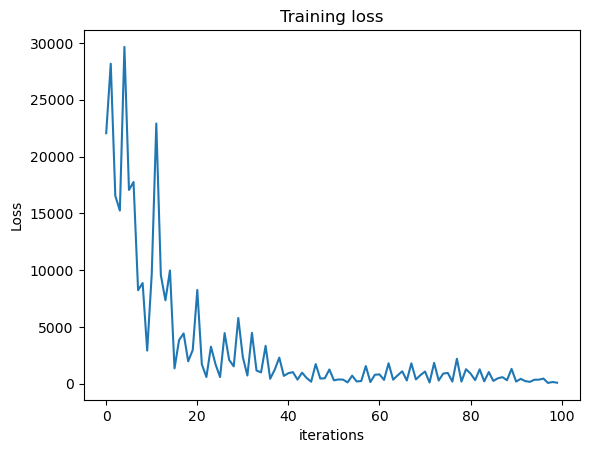

RMSE on model  MIROC-ES2L  :  2.9284998817479884
Epoch  0 , loss= 22057.931640625
Epoch  5 , loss= 17060.654296875
Epoch  10 , loss= 9658.51171875
Epoch  15 , loss= 1352.849365234375
Epoch  20 , loss= 8252.509765625
Epoch  25 , loss= 586.9561767578125
Epoch  30 , loss= 2336.751220703125
Epoch  35 , loss= 3328.600830078125
Epoch  40 , loss= 927.658203125
Epoch  45 , loss= 175.70643615722656
Epoch  50 , loss= 301.4554138183594
Epoch  55 , loss= 198.1667938232422
Epoch  60 , loss= 821.1934204101562
Epoch  65 , loss= 1095.223876953125
Epoch  70 , loss= 1076.6458740234375
Epoch  75 , loss= 950.1571655273438
Epoch  80 , loss= 896.3052978515625
Epoch  85 , loss= 248.84803771972656
Epoch  90 , loss= 189.59703063964844
Epoch  95 , loss= 355.1739501953125


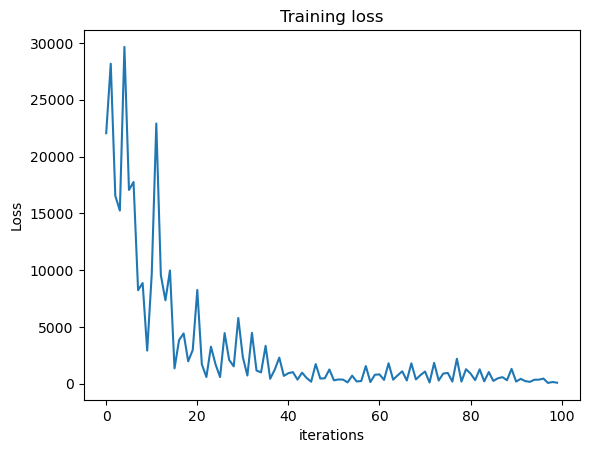

RMSE on model  HadGEM3-GC31-MM  :  3.1716476184515017
Epoch  0 , loss= 22057.931640625
Epoch  5 , loss= 17060.654296875
Epoch  10 , loss= 9658.51171875
Epoch  15 , loss= 1352.849365234375
Epoch  20 , loss= 8252.509765625
Epoch  25 , loss= 586.9561767578125
Epoch  30 , loss= 2336.751220703125
Epoch  35 , loss= 3328.600830078125
Epoch  40 , loss= 927.658203125
Epoch  45 , loss= 175.70643615722656
Epoch  50 , loss= 301.4554138183594
Epoch  55 , loss= 198.1667938232422
Epoch  60 , loss= 821.1934204101562
Epoch  65 , loss= 1095.223876953125
Epoch  70 , loss= 1076.6458740234375
Epoch  75 , loss= 950.1571655273438
Epoch  80 , loss= 896.3052978515625
Epoch  85 , loss= 248.84803771972656
Epoch  90 , loss= 189.59703063964844
Epoch  95 , loss= 355.1739501953125


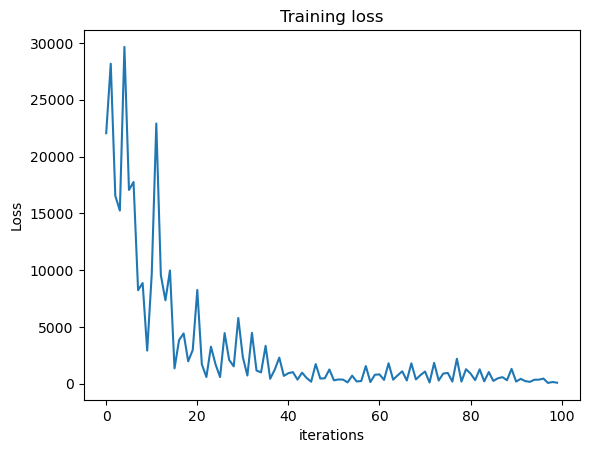

RMSE on model  CanESM5-CanOE  :  12.760511107768354
Epoch  0 , loss= 22057.931640625
Epoch  5 , loss= 17060.654296875
Epoch  10 , loss= 9658.51171875
Epoch  15 , loss= 1352.849365234375
Epoch  20 , loss= 8252.509765625
Epoch  25 , loss= 1027.5509033203125
Epoch  30 , loss= 2500.324951171875
Epoch  35 , loss= 6618.20751953125
Epoch  40 , loss= 757.477783203125
Epoch  45 , loss= 1757.2109375
Epoch  50 , loss= 6673.29345703125
Epoch  55 , loss= 2031.65478515625
Epoch  60 , loss= 353.8983154296875
Epoch  65 , loss= 339.525146484375
Epoch  70 , loss= 709.5604248046875
Epoch  75 , loss= 150.14785766601562
Epoch  80 , loss= 109.49147033691406
Epoch  85 , loss= 46.22480010986328
Epoch  90 , loss= 75.84654235839844
Epoch  95 , loss= 51.11183547973633


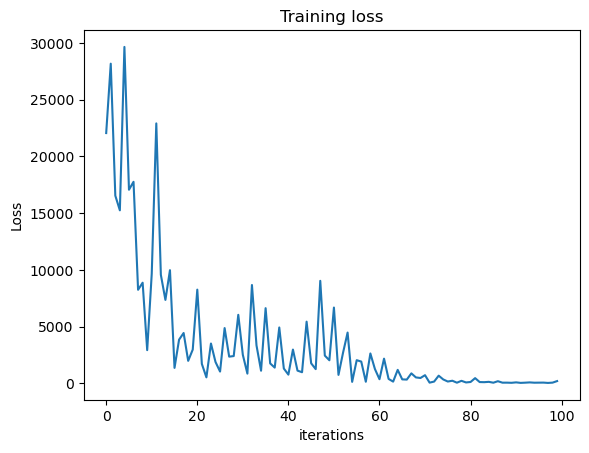

RMSE on model  EC-Earth3  :  105.87101091923365
Epoch  0 , loss= 22057.931640625
Epoch  5 , loss= 17060.654296875
Epoch  10 , loss= 9658.51171875
Epoch  15 , loss= 1352.849365234375
Epoch  20 , loss= 8252.509765625
Epoch  25 , loss= 586.9561767578125
Epoch  30 , loss= 2336.751220703125
Epoch  35 , loss= 3328.600830078125
Epoch  40 , loss= 927.658203125
Epoch  45 , loss= 128.70516967773438
Epoch  50 , loss= 121.83431243896484
Epoch  55 , loss= 565.0668334960938
Epoch  60 , loss= 457.37542724609375
Epoch  65 , loss= 459.94097900390625
Epoch  70 , loss= 583.4400024414062
Epoch  75 , loss= 337.68304443359375
Epoch  80 , loss= 134.574951171875
Epoch  85 , loss= 58.074676513671875
Epoch  90 , loss= 20.169031143188477
Epoch  95 , loss= 41.921077728271484


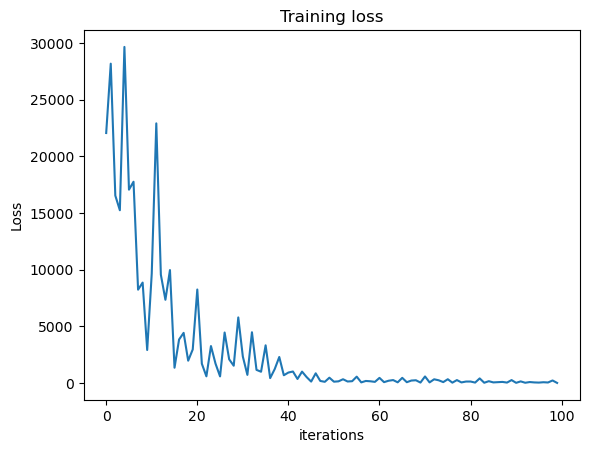

RMSE on model  KACE-1-0-G  :  38.39626364084958
Epoch  0 , loss= 22057.931640625
Epoch  5 , loss= 17060.654296875
Epoch  10 , loss= 9658.51171875
Epoch  15 , loss= 1352.849365234375
Epoch  20 , loss= 8252.509765625
Epoch  25 , loss= 586.9561767578125
Epoch  30 , loss= 2336.751220703125
Epoch  35 , loss= 3328.600830078125
Epoch  40 , loss= 927.658203125
Epoch  45 , loss= 175.70643615722656
Epoch  50 , loss= 301.4554138183594
Epoch  55 , loss= 198.1667938232422
Epoch  60 , loss= 821.1934204101562
Epoch  65 , loss= 1095.223876953125
Epoch  70 , loss= 1076.6458740234375
Epoch  75 , loss= 950.1571655273438
Epoch  80 , loss= 896.3052978515625
Epoch  85 , loss= 248.84803771972656
Epoch  90 , loss= 189.59703063964844
Epoch  95 , loss= 355.1739501953125


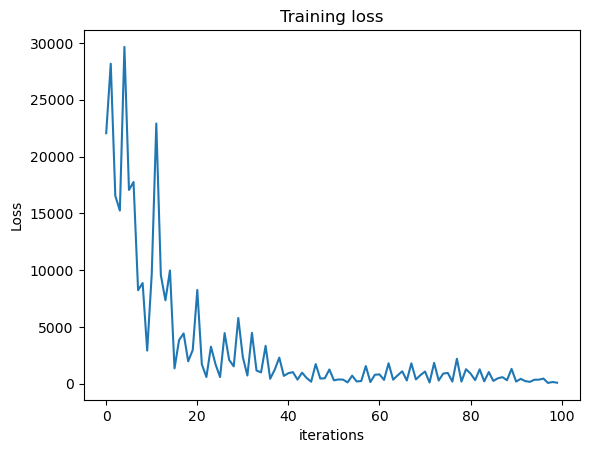

RMSE on model  GISS-E2-1-H  :  0.6610650736523801
Epoch  0 , loss= 22057.931640625
Epoch  5 , loss= 17060.654296875
Epoch  10 , loss= 9658.51171875
Epoch  15 , loss= 1352.849365234375
Epoch  20 , loss= 8252.509765625
Epoch  25 , loss= 586.9561767578125
Epoch  30 , loss= 2336.751220703125
Epoch  35 , loss= 3328.600830078125
Epoch  40 , loss= 927.658203125
Epoch  45 , loss= 175.70643615722656
Epoch  50 , loss= 301.4554138183594
Epoch  55 , loss= 198.1667938232422
Epoch  60 , loss= 821.1934204101562
Epoch  65 , loss= 1095.223876953125
Epoch  70 , loss= 1076.6458740234375
Epoch  75 , loss= 950.1571655273438
Epoch  80 , loss= 896.3052978515625
Epoch  85 , loss= 248.84803771972656
Epoch  90 , loss= 189.59703063964844
Epoch  95 , loss= 355.1739501953125


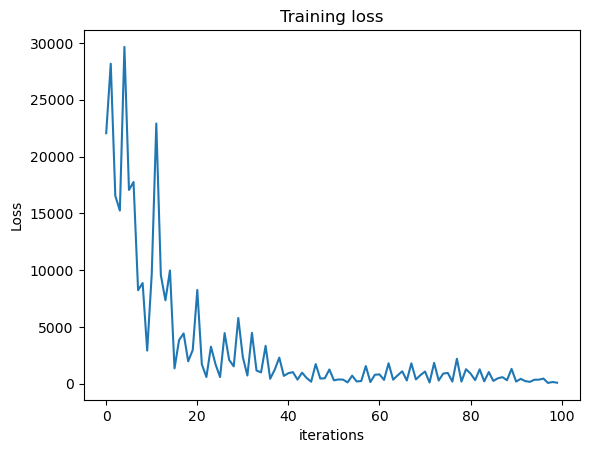

RMSE on model  EC-Earth3-Veg  :  1.5990780724189955
Epoch  0 , loss= 22057.931640625
Epoch  5 , loss= 17060.654296875
Epoch  10 , loss= 9658.51171875
Epoch  15 , loss= 1352.849365234375
Epoch  20 , loss= 8252.509765625
Epoch  25 , loss= 586.9561767578125
Epoch  30 , loss= 2336.751220703125
Epoch  35 , loss= 3328.600830078125
Epoch  40 , loss= 927.658203125
Epoch  45 , loss= 175.70643615722656
Epoch  50 , loss= 301.4554138183594
Epoch  55 , loss= 198.1667938232422
Epoch  60 , loss= 821.1934204101562
Epoch  65 , loss= 1095.223876953125
Epoch  70 , loss= 1076.6458740234375
Epoch  75 , loss= 950.1571655273438
Epoch  80 , loss= 896.3052978515625
Epoch  85 , loss= 248.84803771972656
Epoch  90 , loss= 189.59703063964844
Epoch  95 , loss= 355.1739501953125


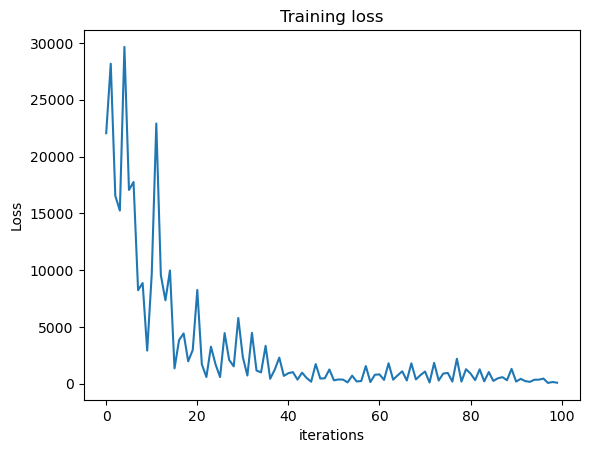

RMSE on model  HadGEM3-GC31-LL  :  7.883497100937975
Epoch  0 , loss= 22057.931640625
Epoch  5 , loss= 17060.654296875
Epoch  10 , loss= 9658.51171875
Epoch  15 , loss= 1352.849365234375
Epoch  20 , loss= 8252.509765625
Epoch  25 , loss= 586.9561767578125
Epoch  30 , loss= 2336.751220703125
Epoch  35 , loss= 3328.600830078125
Epoch  40 , loss= 927.658203125
Epoch  45 , loss= 175.70643615722656
Epoch  50 , loss= 301.4554138183594
Epoch  55 , loss= 198.1667938232422
Epoch  60 , loss= 821.1934204101562
Epoch  65 , loss= 1095.223876953125
Epoch  70 , loss= 1076.6458740234375
Epoch  75 , loss= 950.1571655273438
Epoch  80 , loss= 896.3052978515625
Epoch  85 , loss= 248.84803771972656
Epoch  90 , loss= 189.59703063964844
Epoch  95 , loss= 355.1739501953125


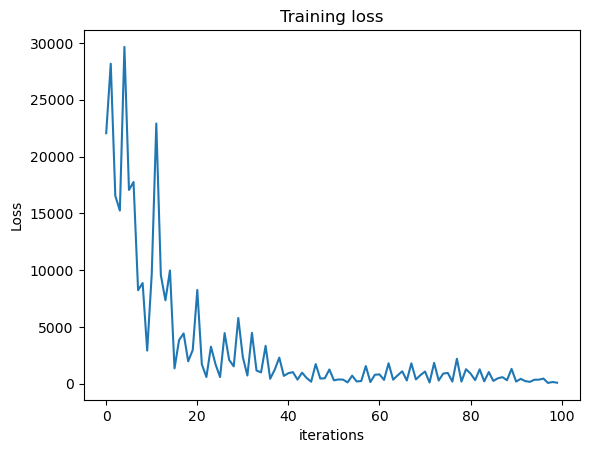

RMSE on model  MIROC6  :  3.345699575506974
Epoch  0 , loss= 22057.931640625
Epoch  5 , loss= 17060.654296875
Epoch  10 , loss= 9658.51171875
Epoch  15 , loss= 1352.849365234375
Epoch  20 , loss= 8252.509765625
Epoch  25 , loss= 586.9561767578125
Epoch  30 , loss= 2336.751220703125
Epoch  35 , loss= 3328.600830078125
Epoch  40 , loss= 927.658203125
Epoch  45 , loss= 175.70643615722656
Epoch  50 , loss= 301.4554138183594
Epoch  55 , loss= 198.1667938232422
Epoch  60 , loss= 821.1934204101562
Epoch  65 , loss= 1095.223876953125
Epoch  70 , loss= 1076.6458740234375
Epoch  75 , loss= 950.1571655273438
Epoch  80 , loss= 896.3052978515625
Epoch  85 , loss= 248.84803771972656
Epoch  90 , loss= 189.59703063964844
Epoch  95 , loss= 355.1739501953125


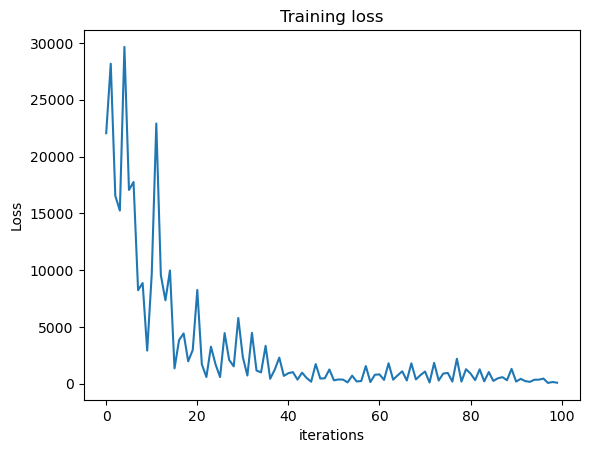

RMSE on model  CESM2  :  5.187014964019775
Epoch  0 , loss= 1645.2183837890625
Epoch  5 , loss= 5519.60009765625
Epoch  10 , loss= 45485.0390625
Epoch  15 , loss= 13110.4580078125
Epoch  20 , loss= 435.2341003417969
Epoch  25 , loss= 2452.725341796875
Epoch  30 , loss= 3328.63427734375
Epoch  35 , loss= 892.1760864257812
Epoch  40 , loss= 247.26551818847656
Epoch  45 , loss= 269.8530578613281
Epoch  50 , loss= 272.5709533691406
Epoch  55 , loss= 104.19390106201172
Epoch  60 , loss= 176.0922088623047
Epoch  65 , loss= 143.60194396972656
Epoch  70 , loss= 95.3653793334961
Epoch  75 , loss= 64.33397674560547
Epoch  80 , loss= 32.40426254272461
Epoch  85 , loss= 33.05807113647461
Epoch  90 , loss= 22.553808212280273
Epoch  95 , loss= 18.139039993286133


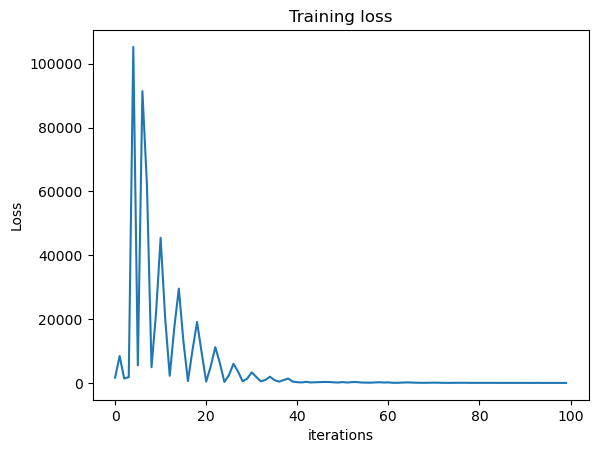

RMSE on model  FGOALS-g3  :  2829.7914764054835
Epoch  0 , loss= 22057.931640625
Epoch  5 , loss= 17060.654296875
Epoch  10 , loss= 9658.51171875
Epoch  15 , loss= 1352.849365234375
Epoch  20 , loss= 8252.509765625
Epoch  25 , loss= 586.9561767578125
Epoch  30 , loss= 2336.751220703125
Epoch  35 , loss= 3328.600830078125
Epoch  40 , loss= 927.658203125
Epoch  45 , loss= 175.70643615722656
Epoch  50 , loss= 301.4554138183594
Epoch  55 , loss= 198.1667938232422
Epoch  60 , loss= 821.1934204101562
Epoch  65 , loss= 1095.223876953125
Epoch  70 , loss= 1076.6458740234375
Epoch  75 , loss= 950.1571655273438
Epoch  80 , loss= 896.3052978515625
Epoch  85 , loss= 248.84803771972656
Epoch  90 , loss= 189.59703063964844
Epoch  95 , loss= 355.1739501953125


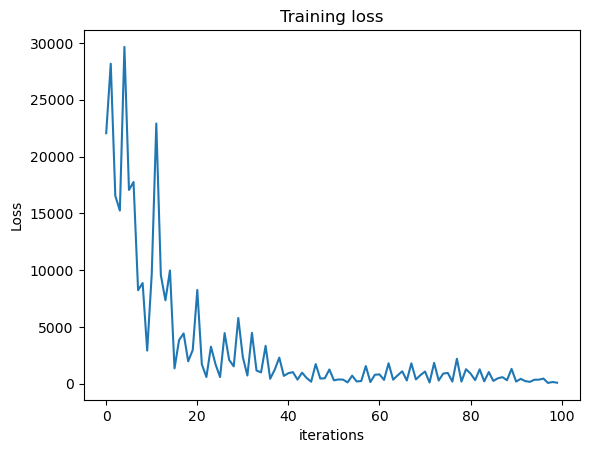

RMSE on model  GISS-E2-1-G  :  0.6116211021403987
Epoch  0 , loss= 22057.931640625
Epoch  5 , loss= 17060.654296875
Epoch  10 , loss= 9658.51171875
Epoch  15 , loss= 1352.849365234375
Epoch  20 , loss= 8252.509765625
Epoch  25 , loss= 586.9561767578125
Epoch  30 , loss= 2336.751220703125
Epoch  35 , loss= 3328.600830078125
Epoch  40 , loss= 927.658203125
Epoch  45 , loss= 175.70643615722656
Epoch  50 , loss= 301.4554138183594
Epoch  55 , loss= 198.1667938232422
Epoch  60 , loss= 821.1934204101562
Epoch  65 , loss= 1095.223876953125
Epoch  70 , loss= 1076.6458740234375
Epoch  75 , loss= 950.1571655273438
Epoch  80 , loss= 896.3052978515625
Epoch  85 , loss= 248.84803771972656
Epoch  90 , loss= 189.59703063964844
Epoch  95 , loss= 355.1739501953125


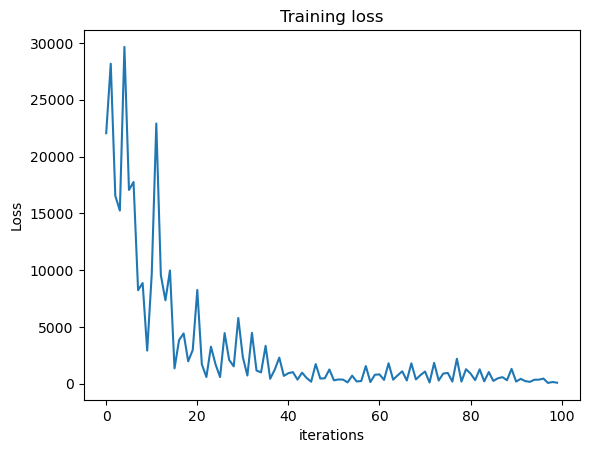

RMSE on model  MRI-ESM2-0  :  10.667562885327621
Epoch  0 , loss= 22057.931640625
Epoch  5 , loss= 17060.654296875
Epoch  10 , loss= 9658.51171875
Epoch  15 , loss= 1352.849365234375
Epoch  20 , loss= 8252.509765625
Epoch  25 , loss= 586.9561767578125
Epoch  30 , loss= 2336.751220703125
Epoch  35 , loss= 3328.600830078125
Epoch  40 , loss= 927.658203125
Epoch  45 , loss= 175.70643615722656
Epoch  50 , loss= 301.4554138183594
Epoch  55 , loss= 198.1667938232422
Epoch  60 , loss= 821.1934204101562
Epoch  65 , loss= 1095.223876953125
Epoch  70 , loss= 1076.6458740234375
Epoch  75 , loss= 950.1571655273438
Epoch  80 , loss= 896.3052978515625
Epoch  85 , loss= 248.84803771972656
Epoch  90 , loss= 189.59703063964844
Epoch  95 , loss= 355.1739501953125


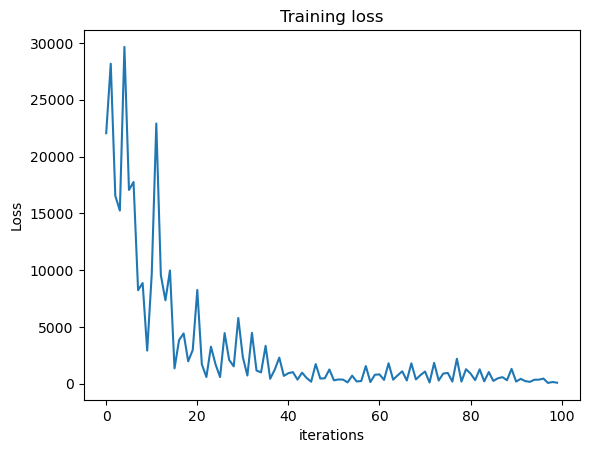

RMSE on model  CESM2-WACCM  :  2.4783106306708245
Epoch  0 , loss= 22057.931640625
Epoch  5 , loss= 17060.654296875
Epoch  10 , loss= 9658.51171875
Epoch  15 , loss= 1352.849365234375
Epoch  20 , loss= 8252.509765625
Epoch  25 , loss= 586.9561767578125
Epoch  30 , loss= 2336.751220703125
Epoch  35 , loss= 3328.600830078125
Epoch  40 , loss= 927.658203125
Epoch  45 , loss= 175.70643615722656
Epoch  50 , loss= 301.4554138183594
Epoch  55 , loss= 198.1667938232422
Epoch  60 , loss= 821.1934204101562
Epoch  65 , loss= 1095.223876953125
Epoch  70 , loss= 1076.6458740234375
Epoch  75 , loss= 950.1571655273438
Epoch  80 , loss= 896.3052978515625
Epoch  85 , loss= 248.84803771972656
Epoch  90 , loss= 189.59703063964844
Epoch  95 , loss= 355.1739501953125


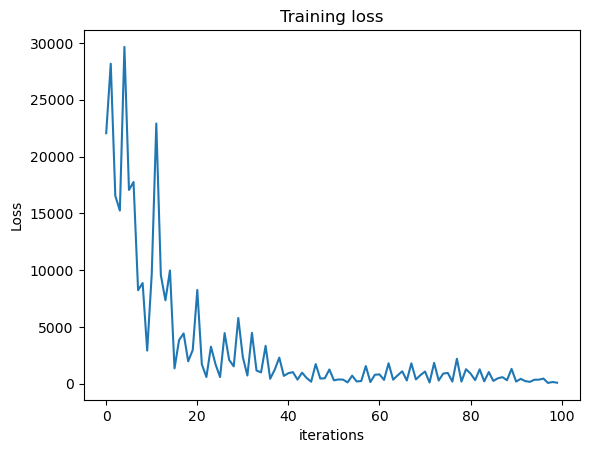

RMSE on model  ACCESS-ESM1-5  :  7.768766429600076
Epoch  0 , loss= 22057.931640625
Epoch  5 , loss= 17060.654296875
Epoch  10 , loss= 9658.51171875
Epoch  15 , loss= 1352.849365234375
Epoch  20 , loss= 8252.509765625
Epoch  25 , loss= 586.9561767578125
Epoch  30 , loss= 2336.751220703125
Epoch  35 , loss= 3328.600830078125
Epoch  40 , loss= 927.658203125
Epoch  45 , loss= 175.70643615722656
Epoch  50 , loss= 301.4554138183594
Epoch  55 , loss= 198.1667938232422
Epoch  60 , loss= 821.1934204101562
Epoch  65 , loss= 1095.223876953125
Epoch  70 , loss= 1076.6458740234375
Epoch  75 , loss= 950.1571655273438
Epoch  80 , loss= 896.3052978515625
Epoch  85 , loss= 248.84803771972656
Epoch  90 , loss= 189.59703063964844
Epoch  95 , loss= 355.1739501953125


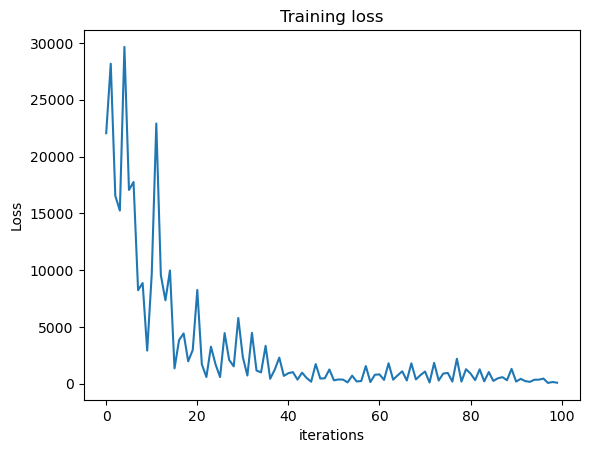

RMSE on model  IPSL-CM6A-LR  :  3.544679946193536
Epoch  0 , loss= 22057.931640625
Epoch  5 , loss= 17060.654296875
Epoch  10 , loss= 9658.51171875
Epoch  15 , loss= 1352.849365234375
Epoch  20 , loss= 8252.509765625
Epoch  25 , loss= 586.9561767578125
Epoch  30 , loss= 2336.751220703125
Epoch  35 , loss= 3328.600830078125
Epoch  40 , loss= 927.658203125
Epoch  45 , loss= 175.70643615722656
Epoch  50 , loss= 301.4554138183594
Epoch  55 , loss= 198.1667938232422
Epoch  60 , loss= 821.1934204101562
Epoch  65 , loss= 1095.223876953125
Epoch  70 , loss= 1076.6458740234375
Epoch  75 , loss= 950.1571655273438
Epoch  80 , loss= 896.3052978515625
Epoch  85 , loss= 248.84803771972656
Epoch  90 , loss= 189.59703063964844
Epoch  95 , loss= 355.1739501953125


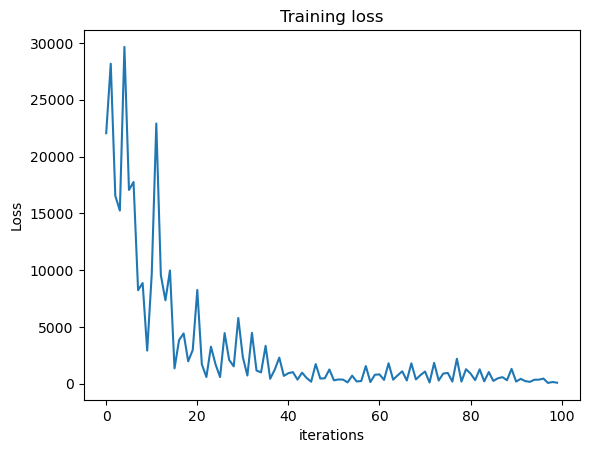

RMSE on model  CanESM5  :  34.35697697327344
Epoch  0 , loss= 22057.931640625
Epoch  5 , loss= 17060.654296875
Epoch  10 , loss= 9658.51171875
Epoch  15 , loss= 1352.849365234375
Epoch  20 , loss= 8252.509765625
Epoch  25 , loss= 586.9561767578125
Epoch  30 , loss= 2336.751220703125
Epoch  35 , loss= 3328.600830078125
Epoch  40 , loss= 927.658203125
Epoch  45 , loss= 175.70643615722656
Epoch  50 , loss= 301.4554138183594
Epoch  55 , loss= 198.1667938232422
Epoch  60 , loss= 821.1934204101562
Epoch  65 , loss= 1095.223876953125
Epoch  70 , loss= 1076.6458740234375
Epoch  75 , loss= 950.1571655273438
Epoch  80 , loss= 896.3052978515625
Epoch  85 , loss= 248.84803771972656
Epoch  90 , loss= 189.59703063964844
Epoch  95 , loss= 355.1739501953125


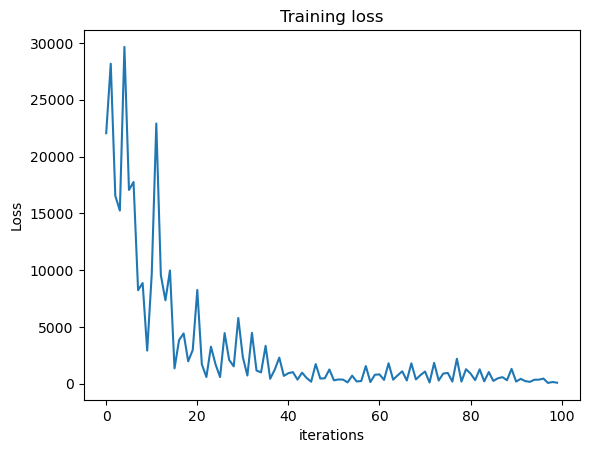

RMSE on model  ACCESS-CM2  :  4.648913161192022
Epoch  0 , loss= 22057.931640625
Epoch  5 , loss= 17060.654296875
Epoch  10 , loss= 9658.51171875
Epoch  15 , loss= 1352.849365234375
Epoch  20 , loss= 8252.509765625
Epoch  25 , loss= 586.9561767578125
Epoch  30 , loss= 2336.751220703125
Epoch  35 , loss= 3328.600830078125
Epoch  40 , loss= 927.658203125
Epoch  45 , loss= 175.70643615722656
Epoch  50 , loss= 301.4554138183594
Epoch  55 , loss= 198.1667938232422
Epoch  60 , loss= 821.1934204101562
Epoch  65 , loss= 1095.223876953125
Epoch  70 , loss= 1076.6458740234375
Epoch  75 , loss= 950.1571655273438
Epoch  80 , loss= 896.3052978515625
Epoch  85 , loss= 248.84803771972656
Epoch  90 , loss= 189.59703063964844
Epoch  95 , loss= 355.1739501953125


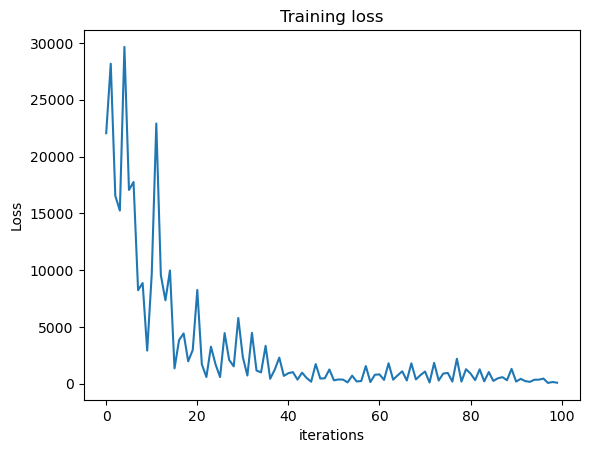

RMSE on model  MPI-ESM1-2-LR  :  6.805972741076373
Epoch  0 , loss= 22057.931640625
Epoch  5 , loss= 17060.654296875
Epoch  10 , loss= 9658.51171875
Epoch  15 , loss= 1352.849365234375
Epoch  20 , loss= 8252.509765625
Epoch  25 , loss= 586.9561767578125
Epoch  30 , loss= 2336.751220703125
Epoch  35 , loss= 3328.600830078125
Epoch  40 , loss= 927.658203125
Epoch  45 , loss= 175.70643615722656
Epoch  50 , loss= 301.4554138183594
Epoch  55 , loss= 198.1667938232422
Epoch  60 , loss= 821.1934204101562
Epoch  65 , loss= 1095.223876953125
Epoch  70 , loss= 1076.6458740234375
Epoch  75 , loss= 950.1571655273438
Epoch  80 , loss= 896.3052978515625
Epoch  85 , loss= 248.84803771972656
Epoch  90 , loss= 189.59703063964844
Epoch  95 , loss= 355.1739501953125


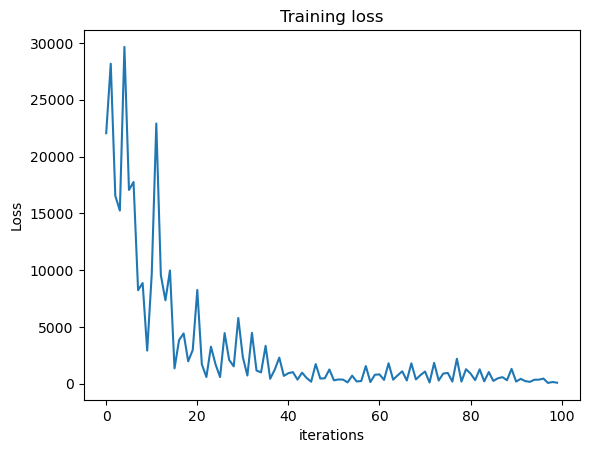

RMSE on model  FGOALS-f3-L  :  2.668382939672634
Epoch  0 , loss= 22057.931640625
Epoch  5 , loss= 12772.4443359375
Epoch  10 , loss= 4406.98681640625
Epoch  15 , loss= 1642.1634521484375
Epoch  20 , loss= 748.1821899414062
Epoch  25 , loss= 418.9485168457031
Epoch  30 , loss= 308.15350341796875
Epoch  35 , loss= 444.62689208984375
Epoch  40 , loss= 135.16368103027344
Epoch  45 , loss= 106.01133728027344
Epoch  50 , loss= 198.26632690429688
Epoch  55 , loss= 137.64889526367188
Epoch  60 , loss= 19.60222625732422
Epoch  65 , loss= 82.9583740234375
Epoch  70 , loss= 41.23093032836914
Epoch  75 , loss= 60.70682907104492
Epoch  80 , loss= 53.5139045715332
Epoch  85 , loss= 99.68704986572266
Epoch  90 , loss= 42.68061828613281
Epoch  95 , loss= 25.31563377380371


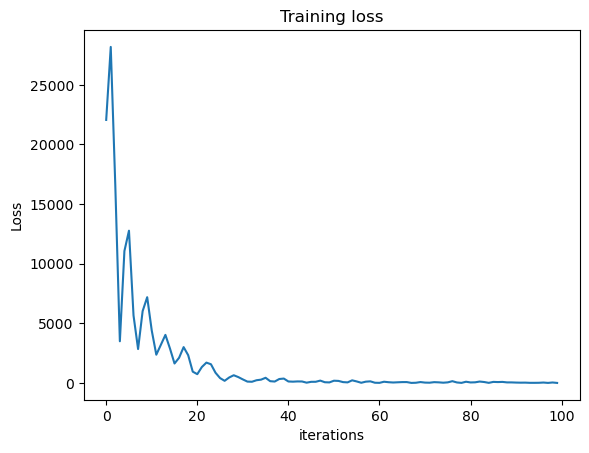

RMSE on model  UKESM1-0-LL  :  726.2335762842638
Check that the weights sum to 1.0  0.9999999999999996


/tmp/ipykernel_21069/2303708381.py:106: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=-90)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


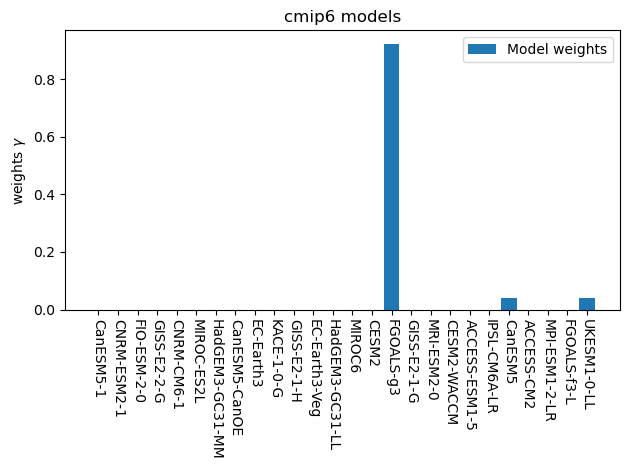

/tmp/ipykernel_21069/2303708381.py:119: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=-90)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


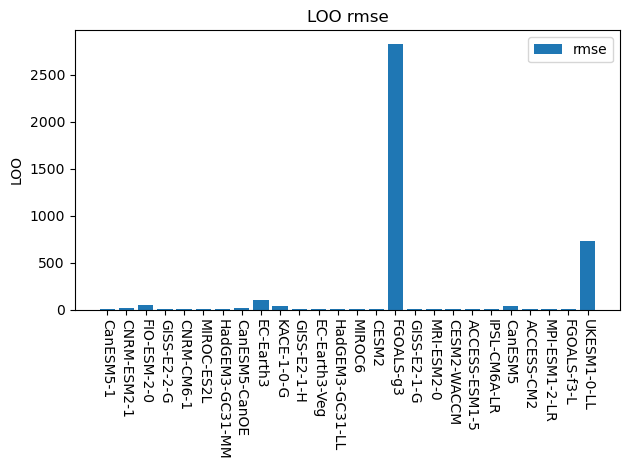

In [60]:
beta, rmse, weights = leave_one_out_procedure(x_predictor,y_forced_response,variance_processed_ssp585,\
                                                grid_lon_size,grid_lat_size,\
                                                lambda_=0.01,method='robust',alpha_=1e-5,\
                                                nbEpochs=100,verbose=True)

In [61]:
weights

{'CanESM5-1': 0.0,
 'CNRM-ESM2-1': 0.0,
 'FIO-ESM-2-0': 0.0,
 'GISS-E2-2-G': 0.0,
 'CNRM-CM6-1': 0.0,
 'MIROC-ES2L': 0.0,
 'HadGEM3-GC31-MM': 0.0,
 'CanESM5-CanOE': 0.0,
 'EC-Earth3': 0.0,
 'KACE-1-0-G': 0.0,
 'GISS-E2-1-H': 0.0,
 'EC-Earth3-Veg': 0.0,
 'HadGEM3-GC31-LL': 0.0,
 'MIROC6': 0.0,
 'CESM2': 0.0,
 'FGOALS-g3': 0.9230769230769227,
 'GISS-E2-1-G': 0.0,
 'MRI-ESM2-0': 0.0,
 'CESM2-WACCM': 0.0,
 'ACCESS-ESM1-5': 0.0,
 'IPSL-CM6A-LR': 0.0,
 'CanESM5': 0.038461538461538464,
 'ACCESS-CM2': 0.0,
 'MPI-ESM1-2-LR': 0.0,
 'FGOALS-f3-L': 0.0,
 'UKESM1-0-LL': 0.038461538461538464}

In [50]:
for idx_m, m in enumerate(dic_reduced_ssp585.keys()):
    if idx_m == 0:
        beta_tmp = beta[m]
    else:
        beta_tmp += beta[m]

beta_tmp = beta_tmp / len(list(dic_reduced_ssp585.keys()))

tensor([ 5.6643,  6.2812, 13.7013,  1.0921,  6.5369,  2.0727,  1.6389,  5.0312,
         2.8623,  5.6896,  0.8045,  1.3498,  4.3729,  2.3988,  3.1692,  8.6793,
         0.7466,  2.6475,  1.9019,  3.3268,  2.9802,  6.6370,  2.0089,  2.9398,
         2.1893,  5.3775])
tensor([3.2005e-04, 5.9308e-04, 9.8992e-01, 3.3076e-06, 7.6590e-04, 8.8180e-06,
        5.7144e-06, 1.6992e-04, 1.9422e-05, 3.2824e-04, 2.4810e-06, 4.2800e-06,
        8.7971e-05, 1.2218e-05, 2.6399e-05, 6.5254e-03, 2.3413e-06, 1.5668e-05,
        7.4335e-06, 3.0907e-05, 2.1853e-05, 8.4648e-04, 8.2733e-06, 2.0987e-05,
        9.9090e-06, 2.4023e-04])


/tmp/ipykernel_21069/195386236.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=-90)


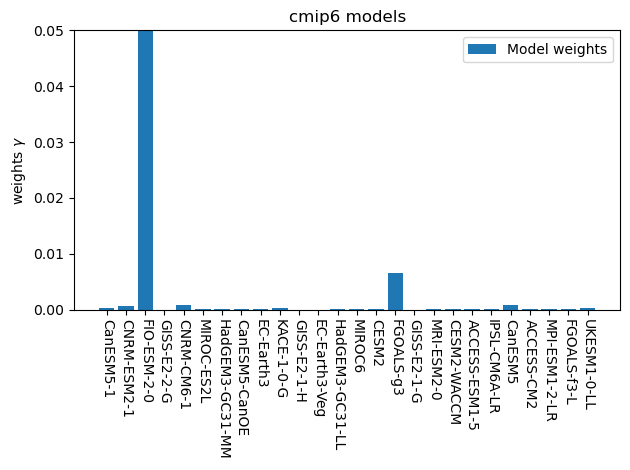

In [63]:
M = len(list(dic_reduced_ssp585.keys()))
gamma = torch.zeros(M)
res = torch.zeros(M,33)

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    
    for idx_i, i in enumerate(dic_reduced_ssp585[m].keys()):
        res[idx_m,:] += (y_train[m][i] - torch.matmul(x_train[m][i],beta_tmp))**2/variance_processed_ssp585[m]
        
    res[idx_m,:] = res[idx_m,:]/len(dic_reduced_ssp585[m].keys())

    gamma[idx_m] = (1/alpha_)*torch.nanmean(res[idx_m,:],axis=0)

print(gamma)
gamma = torch.nn.functional.softmax(gamma,dim=0)
print(gamma)

# plot the model contributions
fig, ax = plt.subplots()
models = list(dic_reduced_ssp585.keys())
weights = list(gamma.detach().numpy())

ax.bar(models, weights,label='Model weights')
ax.set_ylabel(r'weights $\gamma$')
ax.set_ylim(0.0,0.05)
ax.set_title('cmip6 models')
ax.legend()
ax.set_xticklabels(models, rotation=-90)
plt.tight_layout()
plt.show()

In [ ]:
def cross_validation_loo(x,y,vars,lon_size,lat_size,lambda_range,method='robust',alpha_range=np.array([0.1,1.0,10.0]),nbEpochs=500,verbose=True):

    # create the pytorch tensor 
    beta = {}
    rmse = {}
    weights = {}
    y_pred = {}
    y_test = {}

    if method != 'robust':
        alpha_range_tmp = np.array([1.0])
    
    # for each pair (alpha, lambda) perform validation
    
    # for each lambda:
    for idx_lambda, lambda_ in enumerate(lambda_range):

        # for each alpha:
        for idx_alpha, alpha_ in enumerate(alpha_range):

            print("Cross validation: (" + str(alpha_)+", "+ str(lambda_)+ ")")

            beta_tmp, rmse_tmp, weights_tmp = leave_one_out_procedure(x,y,vars,\
                                                                      lon_size,lat_size,\
                                                                      lambda_,method,alpha_,\
                                                                      nbEpochs=2,verbose=False)

            beta[(alpha_,lambda_)] = beta_tmp
            rmse[(alpha_,lambda_)] = rmse_tmp
            weights[(alpha_,lambda_)] = weights_tmp

    return beta, rmse, weights

In [ ]:
# alpha_range = np.linspace(0.5, 1000, num=10)
# lambda_range = np.linspace(0.01, 1000, num=20)


alpha_range = np.array([0.01])
lambda_range = np.array([1.0])

# with open('alpha_range.npy', 'wb') as f:
#     np.save(f, alpha_range)

# with open('lambda_range.npy', 'wb') as f:
#     np.save(f, lambda_range)

# beta_robust, rmse_robust, weights_robust = cross_validation_loo(x_predictor,y_forced_response,variance_processed_ssp585,\
#                                                                 grid_lon_size,grid_lat_size,\
#                                                                 lambda_range,'robust',alpha_range,\
#                                                                 nbEpochs=2,verbose=True)

In [ ]:
# leave_one_out_procedure(x_predictor,y_forced_response,variance_processed_ssp585,\
#               grid_lon_size,grid_lat_size,\
#               alpha_,lambda_,\
#               nbEpochs=1000,verbose=False)

## All models vs Observations

In [ ]:
# alpha_ = 0.5
# lambda_ = 50
# selected_models = list(dic_reduced_ssp585.keys())
# beta_robust = train_robust_model(x_train,y_train,variance_processed_ssp585,\
#                           grid_lat_size,grid_lat_size,\
#                           selected_models,alpha_,lambda_,nbEpochs=1000,verbose=True)

In [ ]:
# # Compute anomalies of X
# x_obs = sst[131:164,:,:]
# x_obs[x_obs<-1e5] = float('nan')

# # Compute mean over space
# y_obs = np.nanmean(x_obs[:,:,:],axis=(1,2))

# # coefficient factor
# beta_softmax_test = beta_robust.detach().numpy().reshape(x_obs.shape[1]*x_obs.shape[2])
# beta_softmax_test[beta_softmax_test>1e3] = 0.0

# y_pred_softmax = np.dot(np.nan_to_num(x_obs).reshape(x_obs.shape[0],x_obs.shape[1]*x_obs.shape[2]),beta_softmax_test)
# # y_pred_reg = np.dot(np.nan_to_num(x_obs).reshape(x_obs.shape[0],x_obs.shape[1]*x_obs.shape[2]),beta_reg_test)

In [ ]:
# minx = np.min(y_obs)
# maxx = np.max(y_obs)
# x_tmp = np.linspace(minx,maxx,100)
# y_tmp = x_tmp


# fig, ax = plt.subplots()
# ax.scatter(y_obs,y_pred_softmax,label='robust')
# ax.plot(x_tmp,y_tmp)
# ax.set_xlabel('observations')
# ax.set_ylabel('predictions')
# ax.legend()
# plt.show()